<a href="https://colab.research.google.com/github/SofiaFreiman/Erythropoiesis/blob/main/Public_datasets_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scanpy leidenalg scikit-misc scvi-tools gprofiler-official pybiomart bbknn celltypist decoupler omnipath scrublet harmonypy
import os
os.kill(os.getpid(), 9)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import time
import os
import pandas as pd
import numpy as np
import scipy.stats
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.external as sce
import anndata
import celltypist
from celltypist import models
import scvi

sc.settings.verbosity = 1
sns.set(font_scale = 1)
sns.set_style("whitegrid")

In [ ]:
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,)

## Integration

In [ ]:
ad1 = sc.read(path + 'AA.h5ad')
ad2 = sc.read(path + 'DBA.h5ad')
ad3 = sc.read(path + 'FA.h5ad')
ad4 = sc.read(path + 'HbbAnemia.h5ad')
ad5 = sc.read(path + "Doty_filtered_annotated_day0.h5ad")

In [ ]:
print(ad1.shape); print(ad2.shape); print(ad3.shape); print(ad4.shape); print(ad5.shape)

(21473, 33538)
(35466, 33538)
(17342, 33538)
(53044, 33694)
(19394, 18827)


<Axes: title={'center': 'GSE222368'}, xlabel='UMAP1', ylabel='UMAP2'>

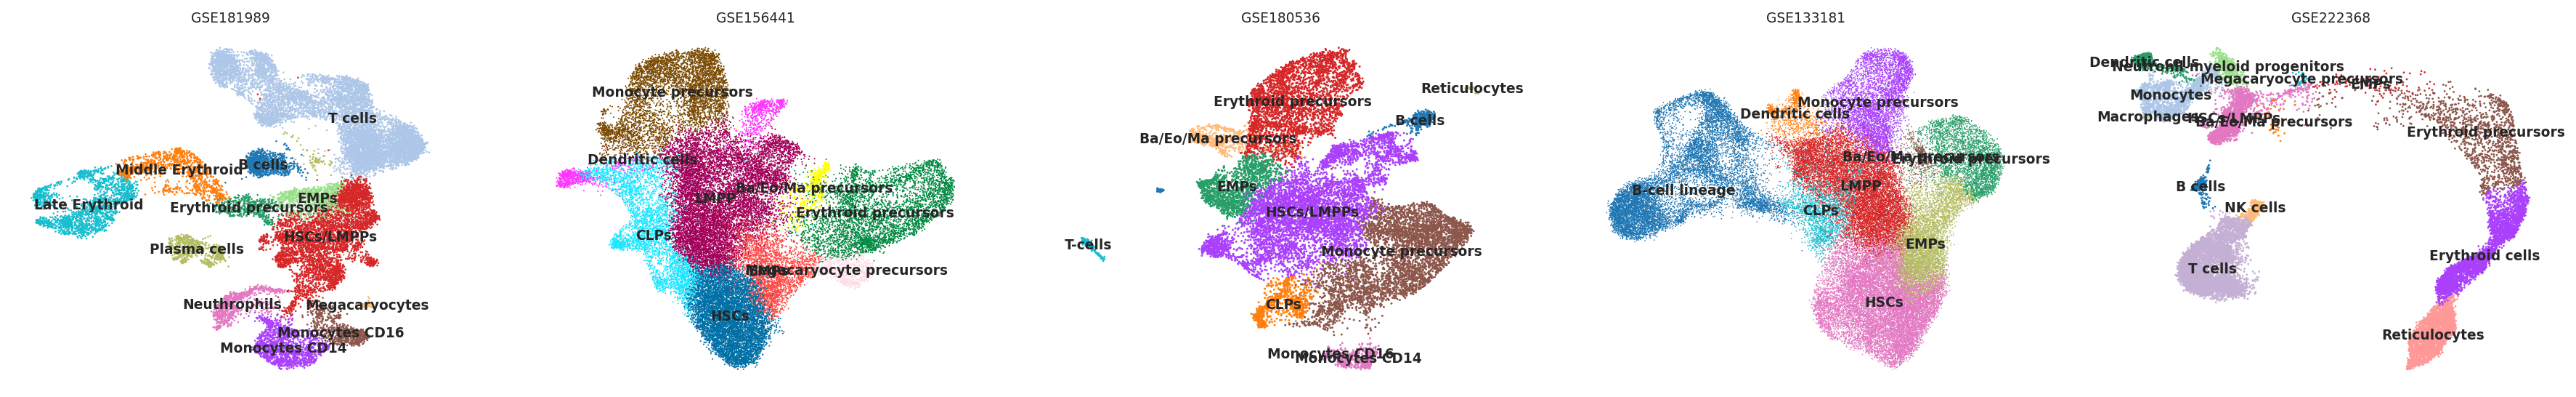

In [ ]:
sns.set(font_scale = 0.7)
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 5, figsize=(28, 4))
sc.pl.umap(ad1, color = 'anno', show = False, ax = axs[0], legend_loc = 'on data', title = list(set(ad1.obs['dataset']))[0])
sc.pl.umap(ad2, color = 'anno', show = False, ax = axs[1], legend_loc = 'on data', title = list(set(ad2.obs['dataset']))[0])
sc.pl.umap(ad3, color = 'anno', show = False, ax = axs[2], legend_loc = 'on data', title = list(set(ad3.obs['dataset']))[0])
sc.pl.umap(ad4, color = 'anno', show = False, ax = axs[3], legend_loc = 'on data', title = list(set(ad4.obs['dataset']))[0])
sc.pl.umap(ad5, color = 'anno', show = False, ax = axs[4], legend_loc = 'on data', title = list(set(ad5.obs['dataset']))[0])

In [ ]:
print(set(ad1.obs['anno']))
print(set(ad2.obs['anno']))
print(set(ad3.obs['anno']))
print(set(ad4.obs['anno']))
print(set(ad5.obs['anno']))

{'Monocytes CD16', 'HSCs/LMPPs', 'B cells', 'EMPs', 'Neuthrophils', 'Monocytes CD14', 'T cells', 'Erythroid precursors', 'Middle Erythroid', 'Plasma cells', 'Late Erythroid', 'Megacaryocytes'}
{'Megacaryocyte precursors', 'EMPs', 'Ba/Eo/Ma precursors', 'HSCs', 'CLPs', 'Erythroid precursors', 'LMPP', 'Dendritic cells', 'Monocyte precursors'}
{'Monocytes CD16', 'B cells', 'EMPs', 'Ba/Eo/Ma precursors', 'T-cells', 'Monocytes CD14', 'Reticulocytes', 'CLPs', 'Erythroid precursors', 'HSCs/LMPPs', 'Monocyte precursors'}
{'EMPs', 'Ba/Eo/Ma precursors', 'B-cell lineage', 'HSCs', 'CLPs', 'Erythroid precursors', 'LMPP', 'Dendritic cells', 'Monocyte precursors'}
{'Neutrohil-myeloid progenitors', 'Megacaryocyte precursors', 'B cells', 'NK cells', 'EMPs', 'Ba/Eo/Ma precursors', 'Reticulocytes', 'T cells', 'Macrophages', 'Erythroid precursors', 'HSCs/LMPPs', 'Dendritic cells', 'Erythroid cells', 'Monocytes'}


In [ ]:
# Broaden annotation - for further usage in supervised integration

ad1.obs['anno_lineage'] = ad1.obs['anno'].replace({'Monocytes CD14' : "Myeloid lineage", 'Megacaryocytes' : "Meg lineage", 'EMPs' : 'HSCs/LMPPs/CLPs/EMPs', 'Monocytes CD16' : "Myeloid lineage", 'HSCs/LMPPs' : 'HSCs/LMPPs/CLPs/EMPs', 'B cells' : 'B-cell lineage', 'T cells' : 'T-cell lineage', })
ad2.obs['anno_lineage'] = ad2.obs['anno'].replace({'EMPs' : 'HSCs/LMPPs/CLPs/EMPs', 'Megacaryocyte precursors' : "Meg lineage", 'LMPP' : 'HSCs/LMPPs/CLPs/EMPs', 'Dendritic cells' : "Myeloid lineage", 'Monocyte precursors' : "Myeloid lineage", 'CLPs' : 'HSCs/LMPPs/CLPs/EMPs', 'HSCs' : 'HSCs/LMPPs/CLPs/EMPs'})
ad3.obs['anno_lineage'] = ad3.obs['anno'].replace({'Monocytes CD14' : "Myeloid lineage", 'EMPs' : 'HSCs/LMPPs/CLPs/EMPs', 'Monocytes CD16' : "Myeloid lineage", 'T-cells' : 'T-cell lineage', 'Monocyte precursors' : "Myeloid lineage", 'CLPs' : 'HSCs/LMPPs/CLPs/EMPs', 'Reticulocytes' : "Late Eryhroid", 'HSCs/LMPPs' : 'HSCs/LMPPs/CLPs/EMPs', 'B cells' : 'B-cell lineage'})
ad4.obs['anno_lineage'] = ad4.obs['anno'].replace({'Dendritic cells' : "Myeloid lineage", 'EMPs' : 'HSCs/LMPPs/CLPs/EMPs', 'LMPP' : 'HSCs/LMPPs/CLPs/EMPs', 'Monocyte precursors' : "Myeloid lineage", 'CLPs' : 'HSCs/LMPPs/CLPs/EMPs', 'HSCs' : 'HSCs/LMPPs/CLPs/EMPs',})
ad5.obs['anno_lineage'] = ad5.obs['anno'].replace({'HSCs/LMPPs' : 'HSCs/LMPPs/CLPs/EMPs', 'B cells' : 'B-cell lineage', 'Monocytes' : "Myeloid lineage", 'Macrophages' : "Myeloid lineage", 'Megacaryocyte precursors' : "Meg lineage", 'Dendritic cells' : "Myeloid lineage",
                                                   'Erythroid cells' : 'Middle Erythroid', 'T cells' : 'T-cell lineage', 'Reticulocytes' : "Late Eryhroid", 'EMPs' : 'HSCs/LMPPs/CLPs/EMPs',
                                                   'Neutrohil-myeloid progenitors' : "Myeloid lineage", 'Ba/Eo/Ma precursors' : "Myeloid lineage", 'NK cells' : "Myeloid lineage"})

In [ ]:
print(set(ad1.obs['anno_lineage']))
print(set(ad2.obs['anno_lineage']))
print(set(ad3.obs['anno_lineage']))
print(set(ad4.obs['anno_lineage']))
print(set(ad5.obs['anno_lineage']))

{'Late Erythroid', 'T-cell lineage', 'B-cell lineage', 'Neuthrophils', 'Meg lineage', 'Myeloid lineage', 'Erythroid precursors', 'Middle Erythroid', 'Plasma cells', 'HSCs/LMPPs/CLPs/EMPs'}
{'Ba/Eo/Ma precursors', 'Meg lineage', 'Myeloid lineage', 'Erythroid precursors', 'HSCs/LMPPs/CLPs/EMPs'}
{'Late Eryhroid', 'Ba/Eo/Ma precursors', 'T-cell lineage', 'B-cell lineage', 'Myeloid lineage', 'Erythroid precursors', 'HSCs/LMPPs/CLPs/EMPs'}
{'Ba/Eo/Ma precursors', 'B-cell lineage', 'Myeloid lineage', 'Erythroid precursors', 'HSCs/LMPPs/CLPs/EMPs'}
{'Late Eryhroid', 'T-cell lineage', 'B-cell lineage', 'Erythroid precursors', 'Meg lineage', 'Myeloid lineage', 'HSCs/LMPPs/CLPs/EMPs', 'Middle Erythroid'}


In [ ]:
print(ad1.X.max())
print(ad2.X.max())
print(ad3.X.max())
print(ad4.X.max())
print(ad5.X.max())
print(ad1.layers['counts'].max())
print(ad2.layers['counts'].max())
print(ad3.layers['counts'].max())
print(ad4.layers['counts'].max())
print(ad5.layers['counts'].max())

8.0145645
7.6855783
8.76669
7.3310466
8.950682
27295.0
2501.0
10764.0
2858.0
49289.0


In [ ]:
label_key = "anno_lineage"
batch_key = "dataset"

adata = ad1.concatenate([ad2, ad3, ad4])
adata.obs.index = [ind.split("-")[0] for ind in adata.obs.index]
ls = ['gene_ids', 'feature_types', 'mt', 'ribo', 'hb',]
for i in adata.var.columns:
  if i not in ls:
    del adata.var[i]
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt', 'ribo', 'hb'], percent_top = None, log1p = False, inplace = True)
sc.pp.highly_variable_genes(adata, n_top_genes = 10000, flavor = "seurat", batch_key = batch_key)
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
print(adata.shape, adata_hvg.shape)

(127325, 22161) (127325, 10000)


In [ ]:
scvi.model.SCVI.setup_anndata(adata_hvg, layer = "lognorm", batch_key = batch_key)
model_scvi = scvi.model.SCVI(adata_hvg, gene_likelihood='nb')
model_scvi.view_anndata_setup()
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
print(max_epochs_scvi)
model_scvi

Anndata setup with scvi-tools version 1.2.1.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'lognorm',
│   'batch_key': 'dataset',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   4    │
│         n_cells          │ 127325 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 10000  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['lognorm']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['dataset'] │ GSE133181  │          0          │
│                      │ GSE156441  │          1          │
│                      │ GSE180536  │          2          │
│                      │ GSE181989  │          3          │
└──────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

63


SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [ ]:
import time
start = time.time()
model_scvi.train()
end = time.time()
print(round((end - start)/60, 1), "min (GPU active)")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=63` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=63` reached.


11.9 min (GPU active)


In [ ]:
adata_hvg.obsm["X_scVI"] = model_scvi.get_latent_representation()
sc.pp.neighbors(adata_hvg, use_rep="X_scVI")
sc.tl.umap(adata_hvg, min_dist = 0.3)

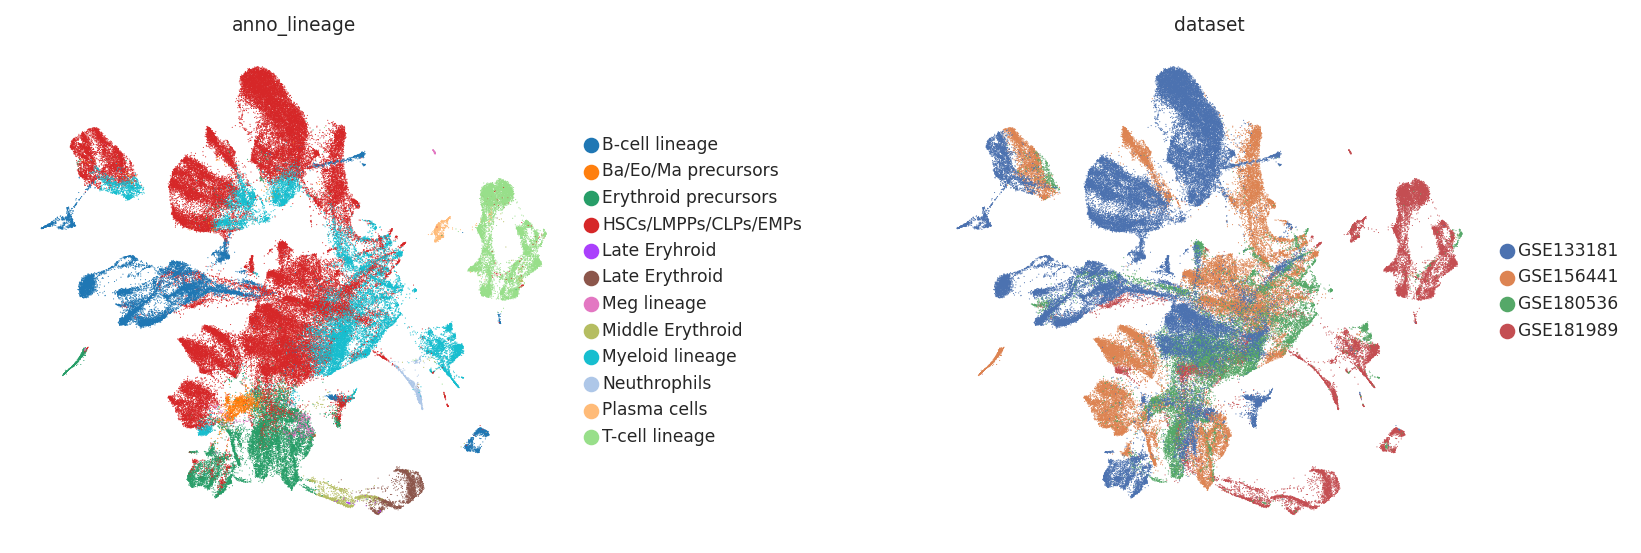

In [ ]:
## Umap after unsupervized batch-correction

sc.pl.umap(adata_hvg, color = ['anno_lineage', 'dataset'], wspace = 0.5)

In [ ]:
model_scanvi = scvi.model.SCANVI.from_scvi_model(model_scvi, labels_key = label_key, unlabeled_category = "", gene_likelihood='nb')
print(model_scanvi)
model_scanvi.view_anndata_setup()
max_epochs_scanvi = int(np.min([10, np.max([2, round(max_epochs_scvi / 3.0)])]))
print(max_epochs_scanvi)
model_scanvi

ScanVI Model with the following params: 
unlabeled_category: , n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Not Trained
Model's adata is minified?: False

Anndata setup with scvi-tools version 1.2.1.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'anno_lineage',
│   'unlabeled_category': '',
│   'layer': 'lognorm',
│   'batch_key': 'dataset',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   4    │
│         n_cells          │ 127325 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   13   │
│          n_vars          │ 10000  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['lognorm']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['dataset'] │ GSE133181  │          0          │
│                      │ GSE156441  │          1          │
│                      │ GSE180536  │          2          │
│                      │ GSE181989  │          3          │
└──────────────────────┴────────────┴─────────────────────┘

                          labels State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃      Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['anno_lineage'] │    B-cell lineage    │          0          │
│                           │ Ba/Eo/Ma precursors  │          1          │
│                           │ Erythroid precursors │          2          │
│                           │ HSCs/LMPPs/CLPs/EMPs │          3          │
│                           │    Late Eryhroid     │          4          │
│                           │    Late Erythroid    │          5          │
│                           │     Meg lineage      │          6          │
│                           │   Middle Erythroid   │          7          │
│                           │   Myeloid lineage    │          8          │
│                           │     Neuthrophils     │          9          │
│                           │     Plasma cells     │         10          │
│                           │    T-cell lineage    │         11          │
│                           │                      │         12          │
└───────────────────────────┴──────────────────────┴─────────────────────┘

10


ScanVI Model with the following params: 
unlabeled_category: , n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Not Trained
Model's adata is minified?: False

In [ ]:
model_scanvi.train(max_epochs=max_epochs_scanvi)

INFO     Training for 10 epochs.                                                                                   


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/10 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
adata_hvg.obsm["X_scANVI"] = model_scanvi.get_latent_representation()
sc.pp.neighbors(adata_hvg, use_rep="X_scANVI")
sc.tl.umap(adata_hvg, min_dist = 0.3)

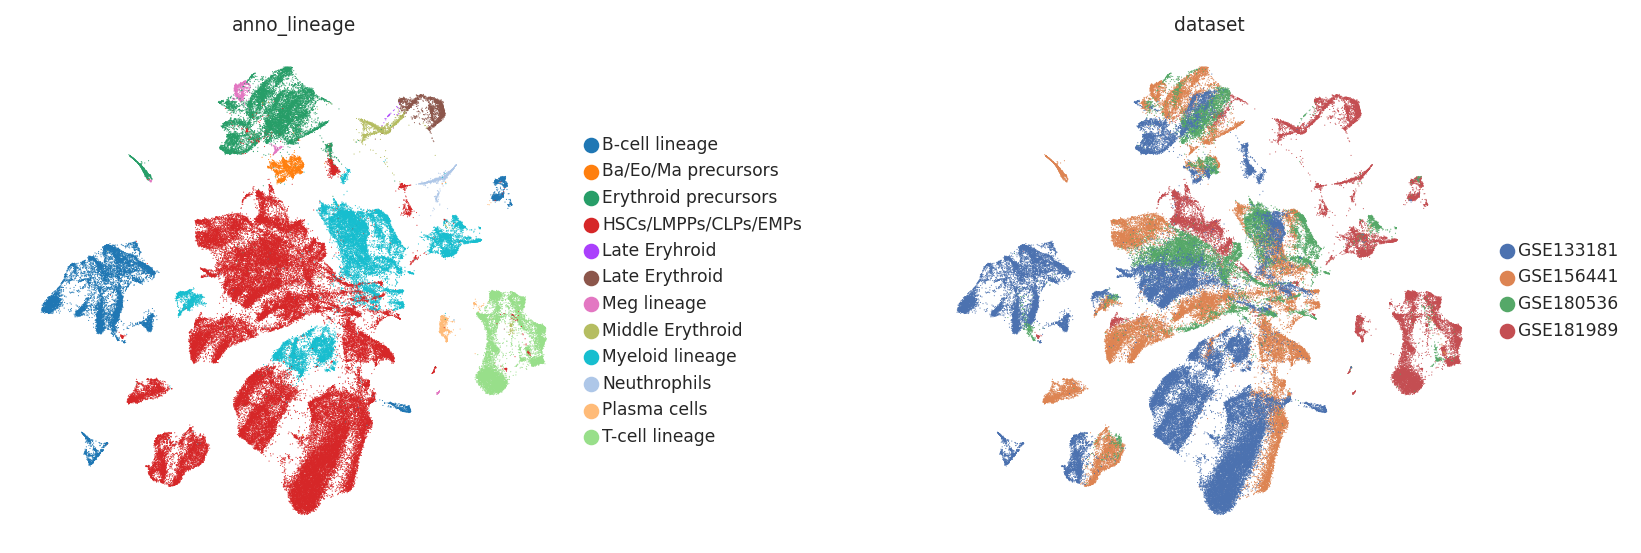

In [ ]:
## Umap after additional supervized trining

sc.pl.umap(adata_hvg, color = ['anno_lineage', 'dataset'], wspace = 0.5)

In [ ]:
adata.obsm["X_scANVI"] = adata_hvg.obsm["X_scANVI"]
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata, min_dist = 0.7)

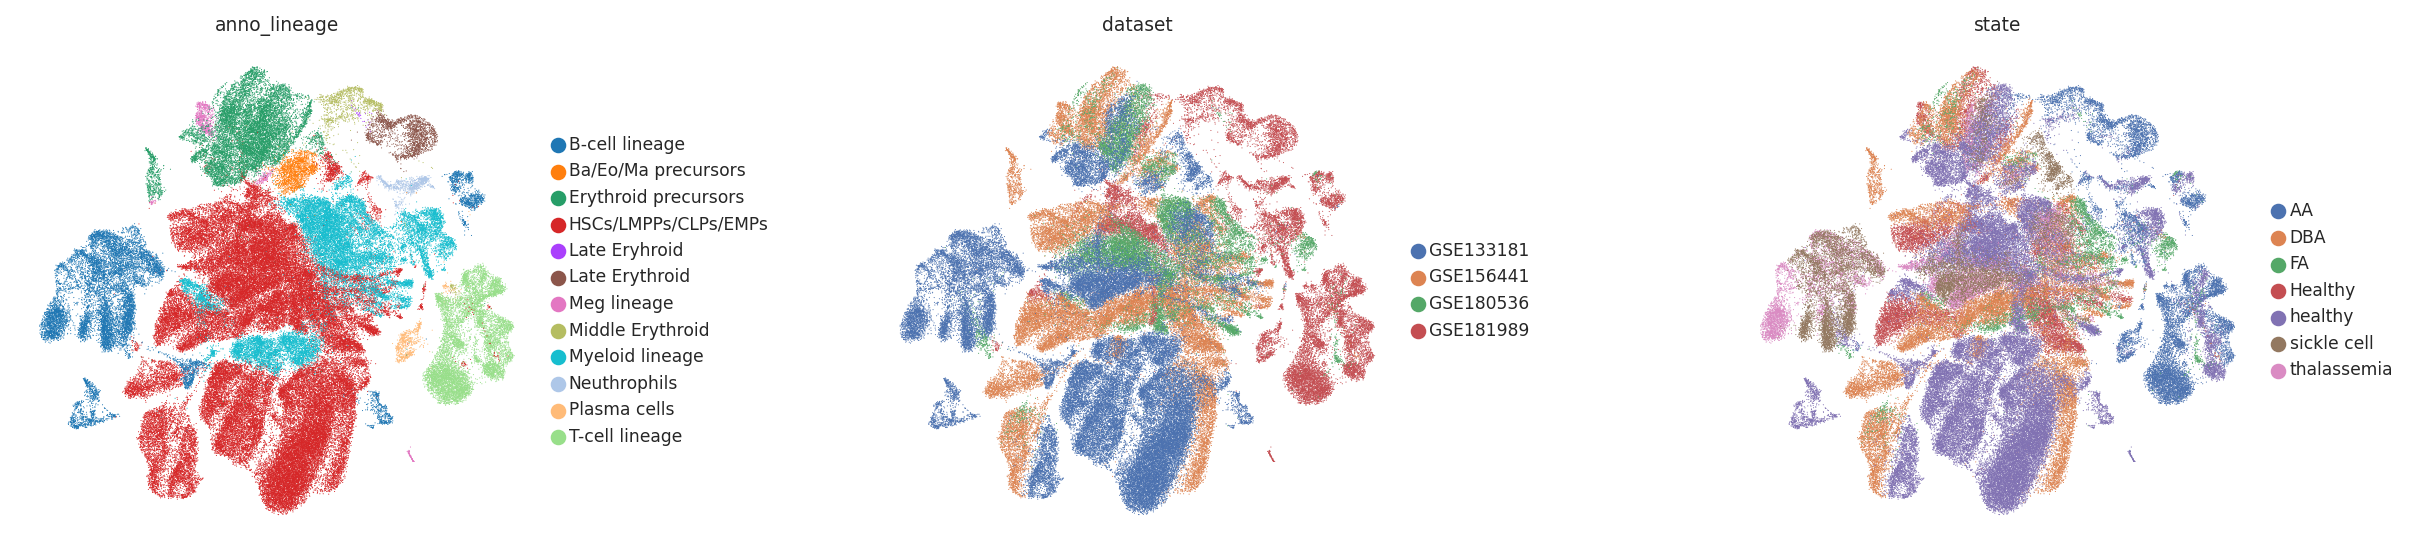

In [ ]:
sc.pl.umap(adata, color = ['anno_lineage', 'dataset', 'state'], wspace = 0.5)

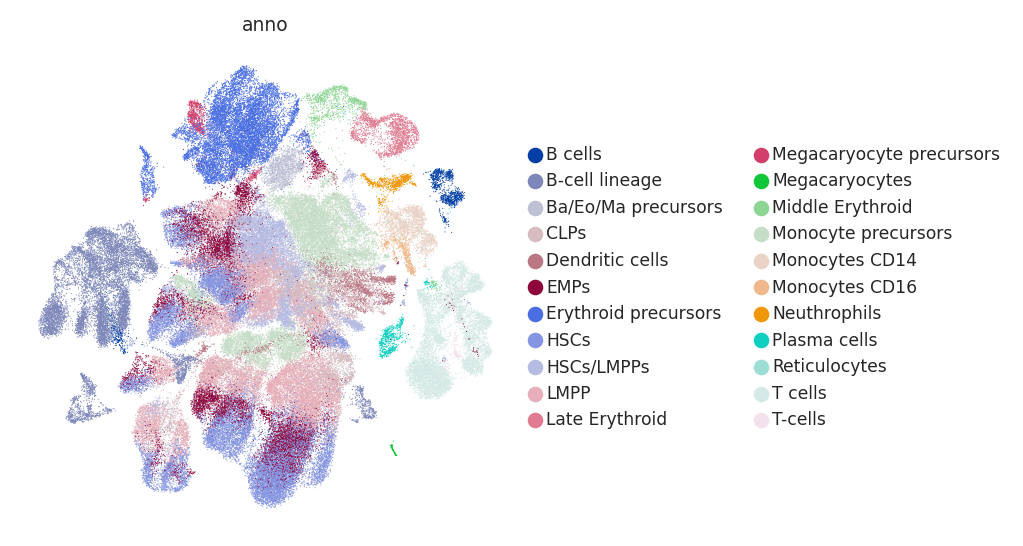

In [ ]:
sc.pl.umap(adata, color = 'anno')

In [ ]:
for i in adata.obs.columns:
  if i not in ['donor', 'dataset', 'state', 'anno', 'anno_lineage']:
    del adata.obs[i]

In [ ]:
adata.write(path + "hematopoiesis_uncultured_integrated.h5ad")

### potential emerging erytropoietic gene

In [ ]:
adata.obs["XACT_pos"] = adata[:, "XACT"].X.A > 0
adata.obs["XACT_pos"] = adata.obs["XACT_pos"].replace({False : "no XACT", True : "XACT-pos"})
print(adata.obs["XACT_pos"].value_counts())

sc.tl.embedding_density(adata, basis='umap', groupby = 'XACT_pos', key_added="XACT_pos_density")

XACT_pos
no XACT     127253
XACT-pos        72
Name: count, dtype: int64


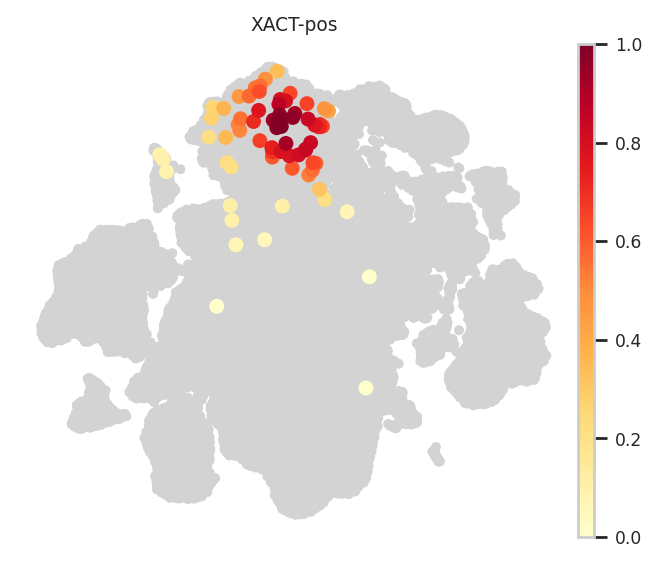

In [ ]:
sc.pl.embedding_density(adata, basis='umap', key='XACT_pos_density', group='XACT-pos')

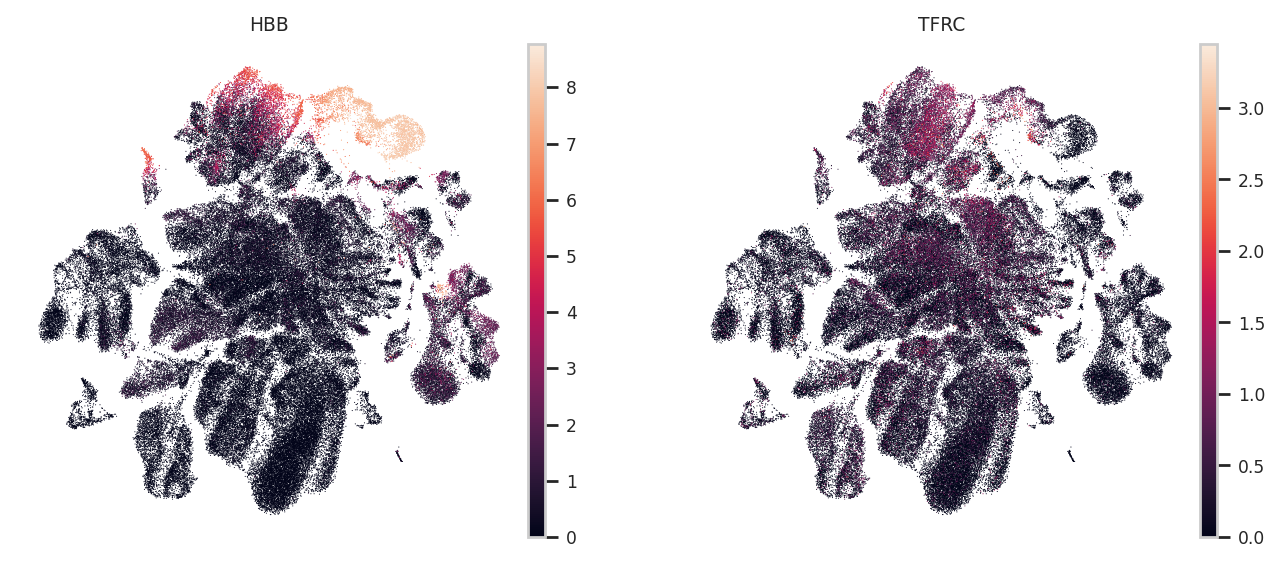

In [ ]:
sc.pl.umap(adata, color = ['HBB', "TFRC"])